[View in Colaboratory](https://colab.research.google.com/github/WilliamHuang1992/Medium/blob/master/Cross_Entropy_vs_Mean_Squared_Error/Cross_Entropy_vs_Mean_Squared_Error.ipynb)

# 1. Cross Entropy vs Mean Squared Error

### 1.1 Import Labraries

In [0]:
# Installation
!pip install -q h5py
!pip install -q keras

In [2]:
from google.colab import files

import six
from six.moves import cPickle
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import adam
from keras.datasets import mnist
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


### 1.2 Load MNIST Data

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print('x_train shape = {}'.format(x_train.shape))
print('y_train shape = {}'.format(y_train.shape))
print('x_test shape  = {}'.format(x_test.shape))
print('y_test shape  = {}'.format(y_test.shape))

x_train shape = (60000, 28, 28)
y_train shape = (60000,)
x_test shape  = (10000, 28, 28)
y_test shape  = (10000,)


### 1.3 Data Engineering

In [0]:
# add channel
x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

# normalization
x_train = x_train / 255
x_test = x_test / 255

# one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
data = (x_train, y_train, x_test, y_test)

In [7]:
print('x_train shape = {}'.format(x_train.shape))
print('y_train shape = {}'.format(y_train.shape))
print('x_test shape  = {}'.format(x_test.shape))
print('y_test shape  = {}'.format(y_test.shape))

x_train shape = (60000, 28, 28, 1)
y_train shape = (60000, 10)
x_test shape  = (10000, 28, 28, 1)
y_test shape  = (10000, 10)


### 1.4 Some Constants

In [0]:
input_shape = (28, 28, 1)
num_classes = 10

batch_size = 64
epochs = 2
iteration = 10

### 1.5 Some Functions

In [0]:
def generate_batch(x, y, batch_size):
    i = 0
    num_batches = len(x) // batch_size
    
    while True:
        start = i * batch_size
        end = (i+1)*batch_size

        batch_x = x[start:end]
        batch_y = y[start:end]
        
        i += 1
        i %= num_batches
        
        yield (batch_x, batch_y)

In [0]:
def get_model(loss):
    model = Sequential()
    
    model.add(Conv2D(input_shape=input_shape, filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(adam(), loss=loss, metrics=['acc'])
    return model

In [0]:
def train_model(data, loss, iteration, batch_size, epochs):
    result = {'train_loss': [],
              'train_acc': [],
              'test_loss': [],
              'test_acc': []
             }
    
    x_train, y_train, x_test, y_test = data
    steps_per_epoch = len(x_train) // batch_size
    
    for i in range(iteration):
        train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
        
        g = generate_batch(x_train, y_train, batch_size)
        model = get_model(loss=loss)

        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                batch_x, batch_y = next(g)
                train_loss, train_acc = model.train_on_batch(batch_x, batch_y)

                train_loss_list.append(train_loss)
                train_acc_list.append(train_acc)

                if step % 75 == 0:
                    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
                    test_loss_list.append(test_loss)
                    test_acc_list.append(test_acc)
            print('Iteration %d, Epoch %d/%d, loss: %.4f, acc: %.4f, val_loss: %.4f, val_acc: %.4f' \
                  %(i+1, epoch+1, epochs, train_loss, train_acc, test_loss, test_acc))
        
        result['train_loss'].append(train_loss_list)
        result['train_acc'].append(train_acc_list)
        result['test_loss'].append(test_loss_list)
        result['test_acc'].append(test_acc_list)
    
    if loss == 'categorical_crossentropy': filepath = 'model_CE.h5'
    if loss == 'mse': filepath = 'model_MSE.h5'
      
    try:
        model.save(filepath)
        print('Saved %s successfully'%filepath)
    except:
        print('Can\'t saved %s'%filepath)
    del model
    
    return result

In [0]:
def plot_comparison(CE_result, MSE_result, ylabel):
    
    colors = ['blue', 'blue', 'r', 'r']
    
    if ylabel == 'Loss':
        data_list = CE_result['train_loss'], CE_result['test_loss'], MSE_result['train_loss'], MSE_result['test_loss']
        CE_average = np.mean([CE_result['test_loss'][i][-1] for i in range(iteration)])
        MSE_average = np.mean([MSE_result['test_loss'][i][-1] for i in range(iteration)])
    if ylabel == 'Accuracy':
        data_list = CE_result['train_acc'], CE_result['test_acc'], MSE_result['train_acc'], MSE_result['test_acc']
        CE_average = np.mean([CE_result['test_acc'][i][-1] for i in range(iteration)])
        MSE_average = np.mean([MSE_result['test_acc'][i][-1] for i in range(iteration)])
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for i in range(4):
        label = None
        ax = axes[i//2, i%2]
        x = np.arange(len(data_list[i][0]))
        
        if i % 2 == 1: x *= 75;
        
        if i == 0: ax.set_title('Training ' + ylabel); ax.set_ylabel('CE');
        if i == 1: ax.set_title('Testing ' + ylabel); label='Average: %.4f'%CE_average
        if i == 2: ax.set_xlabel('Steps'); ax.set_ylabel('MSE')
        if i == 3: ax.set_xlabel('Steps'); label='Average: %.4f'%MSE_average
        
        ax.fill_between(x, np.min(data_list[i], axis=0), np.max(data_list[i], axis=0), alpha=0.3, color=colors[i])
        ax.plot(x, np.mean(data_list[i], axis=0), linewidth=0.1, color=colors[i], label=label)
        ax.legend()

### 1.6 Cross Entropy

In [13]:
CE_result = train_model(data=data,
                        loss='categorical_crossentropy',
                        iteration=iteration,
                        batch_size=batch_size,
                        epochs=epochs
                       )

Iteration 1, Epoch 1/2, loss: 0.3192, acc: 0.9844, val_loss: 0.0961, val_acc: 0.9698
Iteration 1, Epoch 2/2, loss: 0.2810, acc: 0.9844, val_loss: 0.0598, val_acc: 0.9807
Iteration 2, Epoch 1/2, loss: 0.3176, acc: 0.9688, val_loss: 0.0900, val_acc: 0.9716
Iteration 2, Epoch 2/2, loss: 0.3610, acc: 0.9531, val_loss: 0.0575, val_acc: 0.9812
Iteration 3, Epoch 1/2, loss: 0.3934, acc: 0.9375, val_loss: 0.0875, val_acc: 0.9726
Iteration 3, Epoch 2/2, loss: 0.3213, acc: 0.9531, val_loss: 0.0579, val_acc: 0.9811
Iteration 4, Epoch 1/2, loss: 0.3245, acc: 0.9844, val_loss: 0.0914, val_acc: 0.9715
Iteration 4, Epoch 2/2, loss: 0.3254, acc: 0.9531, val_loss: 0.0595, val_acc: 0.9807
Iteration 5, Epoch 1/2, loss: 0.3160, acc: 0.9375, val_loss: 0.0910, val_acc: 0.9714
Iteration 5, Epoch 2/2, loss: 0.2800, acc: 0.9844, val_loss: 0.0585, val_acc: 0.9814
Iteration 6, Epoch 1/2, loss: 0.3241, acc: 0.9688, val_loss: 0.0862, val_acc: 0.9737
Iteration 6, Epoch 2/2, loss: 0.3179, acc: 0.9531, val_loss: 0.05

### 1.7 Mean Squared Error

In [14]:
MSE_result = train_model(data=data,
                         loss='mse',
                         iteration=iteration,
                         batch_size=batch_size,
                         epochs=epochs
                        )

Iteration 1, Epoch 1/2, loss: 0.0072, acc: 0.9688, val_loss: 0.0045, val_acc: 0.9706
Iteration 1, Epoch 2/2, loss: 0.0039, acc: 0.9844, val_loss: 0.0033, val_acc: 0.9788
Iteration 2, Epoch 1/2, loss: 0.0096, acc: 0.9375, val_loss: 0.0049, val_acc: 0.9681
Iteration 2, Epoch 2/2, loss: 0.0053, acc: 0.9688, val_loss: 0.0035, val_acc: 0.9769
Iteration 3, Epoch 1/2, loss: 0.0062, acc: 0.9688, val_loss: 0.0050, val_acc: 0.9665
Iteration 3, Epoch 2/2, loss: 0.0042, acc: 0.9844, val_loss: 0.0034, val_acc: 0.9778
Iteration 4, Epoch 1/2, loss: 0.0056, acc: 0.9688, val_loss: 0.0044, val_acc: 0.9706
Iteration 4, Epoch 2/2, loss: 0.0096, acc: 0.9531, val_loss: 0.0033, val_acc: 0.9784
Iteration 5, Epoch 1/2, loss: 0.0091, acc: 0.9531, val_loss: 0.0049, val_acc: 0.9674
Iteration 5, Epoch 2/2, loss: 0.0089, acc: 0.9219, val_loss: 0.0036, val_acc: 0.9768
Iteration 6, Epoch 1/2, loss: 0.0060, acc: 0.9688, val_loss: 0.0045, val_acc: 0.9705
Iteration 6, Epoch 2/2, loss: 0.0104, acc: 0.9062, val_loss: 0.00

### 1.8 Results

No handles with labels found to put in legend.
No handles with labels found to put in legend.


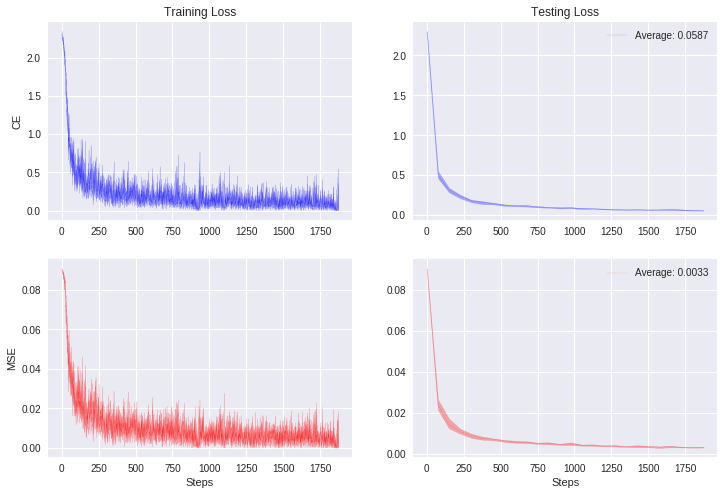

In [15]:
plot_comparison(CE_result, MSE_result, ylabel='Loss')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


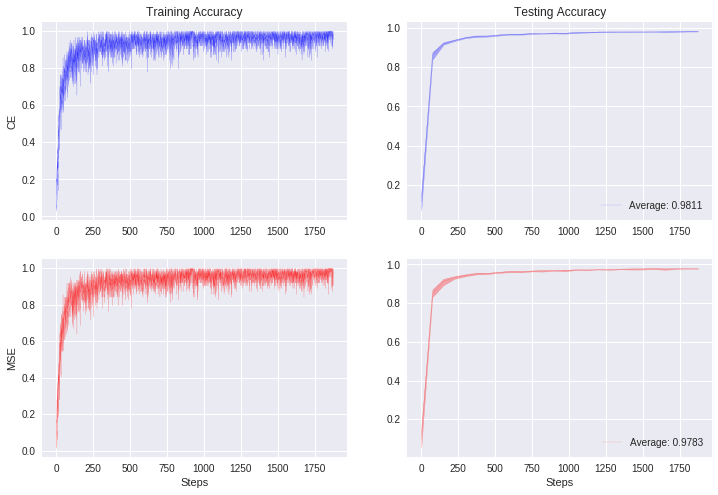

In [16]:
plot_comparison(CE_result, MSE_result, ylabel='Accuracy')

# 2. The figures of CE and MSE

In [107]:
y = np.linspace(0, 1, 50)

CE_label_0 = - np.log(1 - y)
MSE_label_0 = (y - 0)**2

CE_label_1 = - np.log(y)
MSE_label_1 = (y - 1)**2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


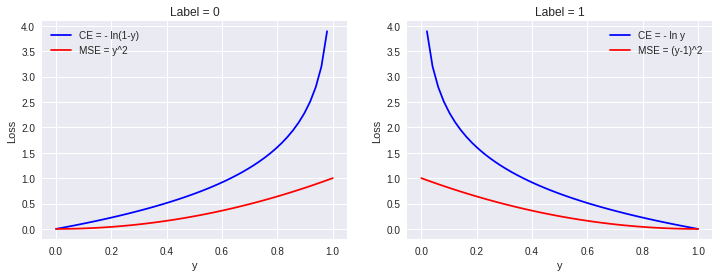

In [108]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(y, CE_label_0, c='blue', label='CE = - ln(1-y)')
plt.plot(y, MSE_label_0, c='red', label='MSE = y^2')
plt.title('Label = 0')
plt.xlabel('y')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y, CE_label_1, c='blue', label='CE = - ln y')
plt.plot(y, MSE_label_1, c='red', label='MSE = (y-1)^2')
plt.title('Label = 1')
plt.xlabel('y')
plt.ylabel('Loss')
plt.legend();

# 3. Landscape

You have load MNIST data first, otherwise please run the sections 1.2 and 1.3

### 3.1 Load Models

1. You can pass this section if you have two models, otherwise please upload the two files 'model_CE.h5' and 'model_MSE.h5'.

2. If you don't have these two files yet, please run the sections 1.

In [0]:
files.upload()

In [0]:
# load models
model_CE = load_model('model_CE.h5')
model_MSE = load_model('model_MSE.h5')

# have to compile models before evaluation
model_CE.compile(adam(), loss='categorical_crossentropy')
model_MSE.compile(adam(), loss='mse')

In [0]:
model_CE_weights = model_CE.get_weights()

In [10]:
print('Conv 1 weights: {}, bias: {}'.format(model_CE_weights[0].shape, model_CE_weights[1].shape))
print('Conv 2 weights: {}, bias: {}'.format(model_CE_weights[2].shape, model_CE_weights[3].shape))
print('FC weight: {}, bias: {}'.format(model_CE_weights[4].shape, model_CE_weights[5].shape))

Conv 1 weights: (3, 3, 1, 16), bias: (16,)
Conv 2 weights: (3, 3, 16, 32), bias: (32,)
FC weight: (1568, 10), bias: (10,)


### 3.2 Some Functions

In [0]:
def normalize(vector):
    '''
    The vectors here we use are a list of numpy arrays,
    hence the usually numpy functions can't handle these vectors.
    '''
    norm = np.sqrt(np.sum([np.sum(component**2) for component in vector]))
    unit_v = [component / norm for component in vector]
    
    return unit_v

In [0]:
def dot(v1, v2):
    '''
    The vectors here we use are a list of numpy arrays,
    hence the usually numpy functions can't handle these vectors.
    '''
    return np.sum([np.sum(v1[i] * v2[i]) for i in range(len(v1))])

In [0]:
def generate_vectors(shape_list):
    # substract 0.5 in order not to get whole positive components
    v1 = [np.random.rand(*shape_list[i])-0.5 for i in range(len(shape_list))]
    v2 = [np.random.rand(*shape_list[i])-0.5 for i in range(len(shape_list))]
    
    # generate unit vector unit_v1
    unit_v1 = normalize(v1)
    
    # find the component of v2 vertical to unit_v1
    v2_horizontal = dot(unit_v1, v2)
    v2_vertical = [v2[i] - unit_v1[i] * v2_horizontal for i in range(len(unit_v1))]
    
    # generate unit vector unit_v2
    unit_v2 = normalize(v2_vertical)
    
    return unit_v1, unit_v2

In [0]:
def loss_landscape(model, data, coordinates, vectors):
    x_train, y_train, x_test, y_test = data
    X, Y = coordinates
    v1, v2 = vectors
    loss = np.zeros((len(X), len(Y)))
    weights = model.get_weights()
    
    for i in range(len(X)):
        # scale v1
        new_v1 = [component * X[i] for component in v1]
        
        for j in range(len(Y)):
            # scale v2
            new_v2 = [component * Y[j] for component in v2]
            
            # since weights of a model is a list of numpy array objects, we need to do deepcopy
            new_weights = copy.deepcopy(weights)
            # update weights
            new_weights[0] += new_v1[0] + new_v2[0] # Conv1 weights
            new_weights[1] += new_v1[1] + new_v2[1] # Conv1 bias
            new_weights[2] += new_v1[2] + new_v2[2] # Conv2 weights
            new_weights[3] += new_v1[3] + new_v2[3] # Conv2 bias
            new_weights[4] += new_v1[4] + new_v2[4] # FC weights
            new_weights[5] += new_v1[5] + new_v2[5] # FC bias
            
            model.set_weights(new_weights)
            loss[i, j] = model.evaluate(x_train, y_train, verbose=0)
            
        print('Complete %2d'%i)
    return loss

### 3.3 Generate Two Random Vertical Unit Vectors and Coordinates

In [0]:
shape_list = [model_CE_weights[0].shape, model_CE_weights[1].shape,
              model_CE_weights[2].shape, model_CE_weights[3].shape,
              model_CE_weights[4].shape, model_CE_weights[5].shape]

vectors = generate_vectors(shape_list)

In [0]:
X = np.linspace(-20, 20, 40)
Y = np.linspace(-20, 20, 40)
coordinates = (X, Y)

XX, YY = np.meshgrid(X, Y)

### 3.4 Plot Loss Landscape

In [17]:
loss_CE = loss_landscape(model_CE, data, coordinates, vectors)

Complete  0
Complete  1
Complete  2
Complete  3
Complete  4
Complete  5
Complete  6
Complete  7
Complete  8
Complete  9
Complete 10
Complete 11
Complete 12
Complete 13
Complete 14
Complete 15
Complete 16
Complete 17
Complete 18
Complete 19
Complete 20
Complete 21
Complete 22
Complete 23
Complete 24
Complete 25
Complete 26
Complete 27
Complete 28
Complete 29
Complete 30
Complete 31
Complete 32
Complete 33
Complete 34
Complete 35
Complete 36
Complete 37
Complete 38
Complete 39


In [0]:
loss_MSE = loss_landscape(model_MSE, data, coordinates, vectors)

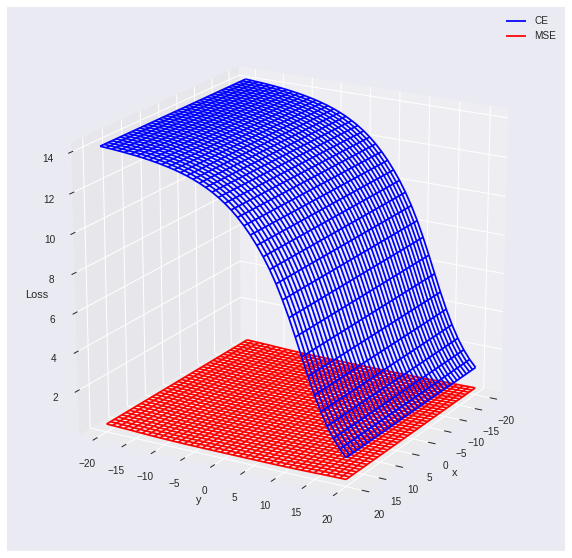

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(XX, YY, loss_CE, color='b', label='CE')
ax.plot_wireframe(XX, YY, loss_MSE, color='r', label='MSE')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Loss')
ax.view_init(20, 30)
plt.legend()
plt.show()

In [0]:
i = 0
for angle in range(0, 360, 5):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(XX, YY, loss_CE, color='b', label='CE')
    ax.plot_wireframe(XX, YY, loss_MSE, color='r', label='MSE')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Loss')
    ax.view_init(20, angle)
    plt.legend()
    
    filename = '3DAnimation_%2d'%i
    plt.savefig(filename, dpi=96)
    plt.gca()
    i += 1

In [35]:
result = (XX, YY, loss_CE, loss_MSE)

with open('result.pkl', 'wb') as f:
    cPickle.dump(result, f)
files.download('result.pkl')
    
for i in range(72):
    files.download('3DAnimation_%2d.png'%i)

SyntaxError: ignored

In [0]:
!convert -delay 15 3DAnimation_*.png 3DAnimation.gif

In [0]:
files.download('3DAnimation.gif')